# 實驗：遷移學習範例

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/taipeitechmmslab/MMSLAB-TF2/blob/master/Lab9.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/taipeitechmmslab/MMSLAB-TF2/blob/master/Lab9.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Import必要套件

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
# 從資料夾中的preprocessing.py檔案中Import flip, color, rotate, zoom影像增強函數
from preprocessing import flip, color, rotate, zoom

### 讀取數據並分析

### cats_vs_dogs
載入cats_vs_dogs數據集

In [2]:
# 將train Data重新分成8:1:1等分，分別分給train data, valid data, test data
train_split, valid_split, test_split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
# 取得訓練數據，並順便讀取data的資訊
train_data, info = tfds.load("cats_vs_dogs", split=train_split, with_info=True)
# 取得驗證數據
valid_data = tfds.load("cats_vs_dogs", split=valid_split)
# 取得測試數據
test_data = tfds.load("cats_vs_dogs", split=test_split)

查看標籤類別，並建立解碼器：

In [3]:
print(info.features['label'].names)
decoder = info.features['label'].names

['cat', 'dog']


顯示數據集部分影像資料：

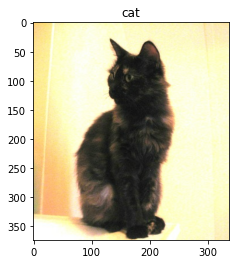

In [4]:
# 每一次取8比資料，共取8次，所以總共取得64比資料
for data in train_data.take(1):
    img = data['image']
    label = data['label']
plt.title(decoder[label])
# 顯示影像
plt.imshow(img)

### Dataset 設定
資料預處理(Data Prepossessing )

訓練資料:
-	標準化：將影像全部除以255，將像素值縮放到0~1之間。
-	影像增強：將影像水平翻轉、影像旋轉、顏色轉換和影像縮放。
-	調整影像大小：將輸入影像調整為網路模型要求格式(299, 299, 3)。

驗證和測試資料:
-	標準化：將影像全部除以255，將像素值縮放到0~1之間。
-	調整影像大小：將輸入影像調整為網路模型要求格式(299, 299, 3)。


In [5]:
input_shape = (299, 299)

In [6]:
def parse_aug_fn(dataset):
    """
    Image Augmentation(影像增強) function
    """
    x = tf.cast(dataset['image'], tf.float32) / 255.  # 影像標準化
    x = tf.image.resize(x, input_shape)
    x = flip(x)  # 隨機水平翻轉
    # 觸發顏色轉換機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x)
    # 觸發影像旋轉機率0.25%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    # 觸發影像縮放機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    return x, dataset['label']

def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.  # 影像標準化
    x = tf.image.resize(x, input_shape)
    return x, dataset['label']

Dataset設定：

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
buffer_size = 1000  # 因為這次的影像較大，緩存空間設1000就好
bacth_size = 32  # 批次大小

# 載入預處理「 parse_aug_fn」function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.shuffle(buffer_size)  # 打散資料集
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)
train_data = train_data.batch(bacth_size).prefetch(buffer_size=AUTOTUNE)

# 載入預處理「 parse_fn」function，cpu數量為自動調整模式
valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)
valid_data = valid_data.batch(bacth_size).prefetch(buffer_size=AUTOTUNE)

# 載入預處理「 parse_fn」function，cpu數量為自動調整模式
test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)
test_data = test_data.batch(bacth_size).prefetch(buffer_size=AUTOTUNE)

### 訓練Model-1(Random Initialization)

創建模型儲存位置：

In [8]:
# !rm -r lab8-logs  # 移除目錄(以防萬一)
model_dir = 'lab9-logs/models'  # 設定儲存權重目錄
os.makedirs(model_dir)  # 創建儲存權重目錄

設定回調函數：

In [9]:
# 儲存訓練記錄檔
log_dir = os.path.join('lab9-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5', 
                                             monitor='val_binary_accuracy', 
                                             save_best_only=True, 
                                             mode='max')
# 設定停止訓練的條件(當Accuracy超過30迭代沒有上升的話訓練會終止)
model_esp = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20)

創建Inception V3網路模型

In [10]:
# 創建模型(不包含全連接層和預訓練權重)，最後一層卷積加上GlobalAveragePooling
base_model = tf.keras.applications.InceptionV3(include_top=False, 
                                               weights=None, 
                                               pooling='avg', 
                                               input_shape=input_shape+(3,))
# 將剛創建的InceptionV3模型接上兩層全連接層，並且最後一層使用Sigmoid輸出
model_1 = tf.keras.Sequential([
    base_model,
    layers.Dense(128, activation='relu'), 
    layers.Dense(1, activation='sigmoid')
])


透過model.summary查看網路模型資訊

In [11]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 22,065,185
Trainable params: 22,030,753
Non-trainable params: 34,432
_________________________________________________________________


設定訓練使用的優化器、損失函數和指標函數

In [12]:
model_1.compile(keras.optimizers.Adam(), 
                loss=keras.losses.BinaryCrossentropy(), 
                metrics=[keras.metrics.BinaryAccuracy()])

訓練網路模型

In [13]:
history = model_1.fit(train_data,
                      epochs=200, 
                      validation_data=valid_data,
                      callbacks=[model_cbk, model_mckp, model_esp])

Epoch 1/200


W0716 10:48:04.863682 139754391103296 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


582/582 [==============================] - 381s 655ms/step - loss: 0.6649 - binary_accuracy: 0.6150 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00
Epoch 2/200
582/582 [==============================] - 285s 489ms/step - loss: 0.5869 - binary_accuracy: 0.6902 - val_loss: 0.6301 - val_binary_accuracy: 0.6853
Epoch 3/200
582/582 [==============================] - 286s 492ms/step - loss: 0.5339 - binary_accuracy: 0.7364 - val_loss: 0.8289 - val_binary_accuracy: 0.7207
Epoch 4/200
582/582 [==============================] - 282s 484ms/step - loss: 0.4765 - binary_accuracy: 0.7767 - val_loss: 0.4959 - val_binary_accuracy: 0.7845
Epoch 5/200
582/582 [==============================] - 281s 483ms/step - loss: 0.3897 - binary_accuracy: 0.8239 - val_loss: 0.3741 - val_binary_accuracy: 0.8642
Epoch 6/200
582/582 [==============================] - 279s 479ms/step - loss: 0.3207 - binary_accuracy: 0.8579 - val_loss: 0.6759 - val_binary_accuracy: 0.7905
Epoch 7/200
582/582 [=================

### 訓練Model-2(Transfer Learning)

建立Callback function：

In [13]:
# 儲存訓練記錄檔
log_dir = os.path.join('lab9-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5', 
                                             monitor='val_binary_accuracy', 
                                             save_best_only=True, 
                                             mode='max')
# 設定停止訓練的條件(當Accuracy超過30迭代沒有上升的話訓練會終止)
model_esp = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20, mode='max')

創建Inception V3網路模型

In [14]:
# 權重檔網址
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

model_2 = tf.keras.Sequential([
    # hub.KerasLayer載入的模型為Keras Layer
    hub.KerasLayer(module_url,
                   input_shape=(299, 299, 3),  # 模型輸入大小
                   output_shape=(2048,),   # 模型輸出打小
                   trainable=False),  # 將模型訓練權重設定為False(凍結)
    # 最後接上兩層全連接層，並且輸出使用Sigmoid
    layers.Dense(128, activation='relu'), 
    layers.Dense(1, activation='sigmoid')
])


透過model.summary查看網路模型資訊

In [15]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 22,065,185
Trainable params: 262,401
Non-trainable params: 21,802,784
_________________________________________________________________


設定訓練使用的優化器、損失函數和指標函數

In [16]:
model_2.compile(keras.optimizers.Adam(), 
               loss=keras.losses.BinaryCrossentropy(), 
               metrics=[keras.metrics.BinaryAccuracy()])

訓練網路模型

In [18]:
history = model_2.fit(train_data,
                      epochs=200, 
                      validation_data=valid_data,
                      callbacks=[model_cbk, model_esp, model_mckp])

Epoch 1/200
582/582 [==============================] - 92s 158ms/step - loss: 0.0799 - binary_accuracy: 0.9736 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00
Epoch 2/200
582/582 [==============================] - 89s 153ms/step - loss: 0.0551 - binary_accuracy: 0.9800 - val_loss: 0.0162 - val_binary_accuracy: 0.9931
Epoch 3/200
582/582 [==============================] - 88s 152ms/step - loss: 0.0502 - binary_accuracy: 0.9825 - val_loss: 0.0168 - val_binary_accuracy: 0.9922
Epoch 4/200
582/582 [==============================] - 88s 151ms/step - loss: 0.0474 - binary_accuracy: 0.9823 - val_loss: 0.0404 - val_binary_accuracy: 0.9849
Epoch 5/200
582/582 [==============================] - 89s 152ms/step - loss: 0.0521 - binary_accuracy: 0.9812 - val_loss: 0.0141 - val_binary_accuracy: 0.9944
Epoch 6/200
582/582 [==============================] - 88s 152ms/step - loss: 0.0455 - binary_accuracy: 0.9827 - val_loss: 0.0160 - val_binary_accuracy: 0.9931
Epoch 7/200
582/582 [===========

### 測試Model-1和Model-2

In [19]:
model_1.load_weights(model_dir + '/Best-model-1.h5')
model_2.load_weights(model_dir + '/Best-model-2.h5')

In [20]:
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)

     73/Unknown - 9s 129ms/step - loss: 0.0174 - binary_accuracy: 0.9940

In [21]:
print("Model_1 Prediction: {}%".format(acc_1 * 100))
print("Model_2 Prediction: {}%".format(acc_2 * 100))

Model_1 Prediction: 97.97413945198059%
Model_2 Prediction: 99.39655065536499%


In [22]:
acc_2 - acc_1

0.014224112